In [108]:
%matplotlib inline

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sky_spot.utils import ClusterType

api = wandb.Api()
plt.rc('font', size=16)

In [109]:
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

TAGS = ['baseline']
DDLs = {20, 20.8, 21, 23, 24}
filters = {
    'env_metadata': lambda x: x['name'] == 'trace' and 'trace_file' in x and '/1.json' in x['trace_file'],
    'strategy_metadata': lambda x: x['name'] == 'strawman',
    'task_duration_hours': lambda x: x == 20,
    'deadline_hours': lambda x: x in DDLs,
}


def filter_run(run):
    return all([f(run.config[k]) for k, f in filters.items()])

run_dfs = []
new_runs = []
for run in runs:
    for tag in TAGS:
        if tag not in run.tags:
            break
    else:
        # all tags found
        df = run.history()
        df['Task/Remaining(hours)'] = df['Task/Remaining(seconds)'] / 3600
        if filter_run(run):
            run_dfs.append((run, df))

run_dfs = sorted(run_dfs, key=lambda x: x[0].config['deadline_hours'], reverse=True)

In [110]:
LINE_STYLES = ['-', '--', ':', '-.', ':']
def plot_y(y_name='ClusterType', is_step_plot=True):
    fig, ax = plt.subplots()
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        if strategy is None:
            strategy = run.config['strategy']
            task_duration = run.config['task_duration_hours']
        else:
            assert strategy == run.config['strategy']
            assert task_duration == run.config['task_duration_hours']
        ddl = run.config['deadline_hours']
        drawstyle = 'steps-pre' if is_step_plot else None
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=f'ddl={ddl}', linestyle=LINE_STYLES[i%len(LINE_STYLES)], drawstyle=drawstyle, ax=ax)
    ax.legend(loc='best')
    return ax, strategy, task_duration

In [111]:
run = runs[0]
run.config['task_duration_hours']

20

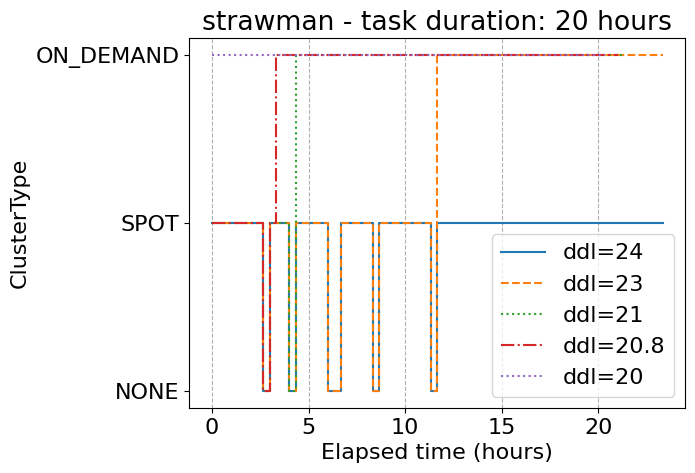

In [112]:
ax, strategy, task_duration = plot_y(y_name='ClusterType')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='x', linestyle='--')

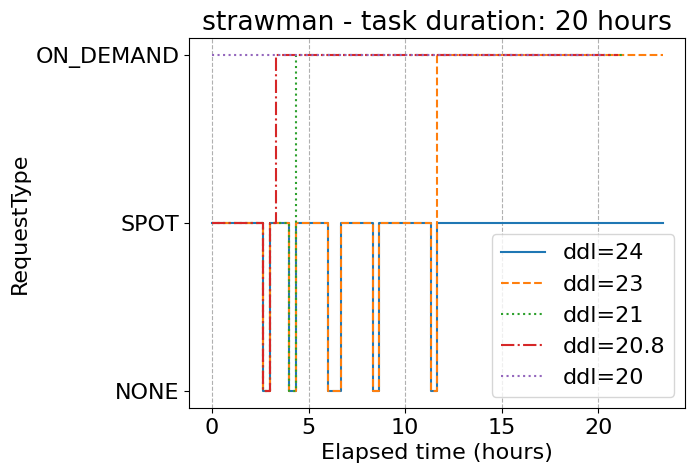

In [113]:
ax, strategy, task_duration = plot_y(y_name='RequestType')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='x', linestyle='--')

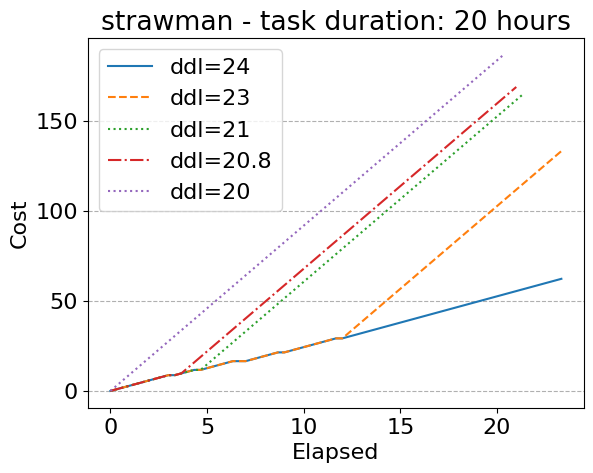

In [114]:
ax, strategy, task_duration = plot_y(y_name='Cost', is_step_plot=False)
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='y', linestyle='--')

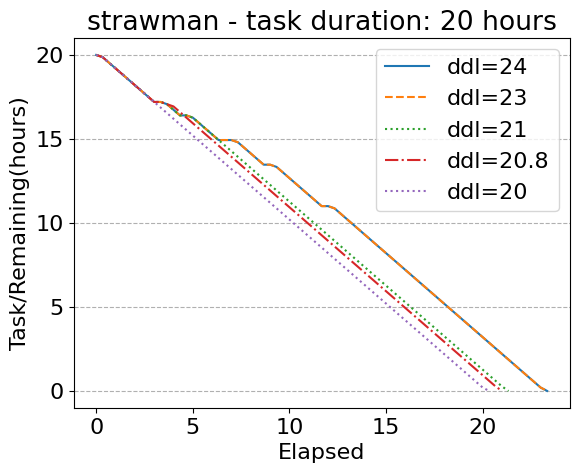

In [115]:
ax, strategy, task_duration = plot_y(y_name='Task/Remaining(hours)', is_step_plot=False)
ax.set_title(f'{strategy} - task duration: {task_duration} hours')
ax.grid(True, which='major', axis='y', linestyle='--')